# Results
<br>
James Chapman<br>
CIS 830 Advanced Topics in AI – Term Project<br>
Kansas State University<br><br>

This notebook collects results from all experiments.<br>

- Synonym matching
- Short prompt (True/False)
- Long prompt (True/False)
- Entity Linking
- Entity Linking with RAG

- Compares results with Hand-Labeled Data ('data/labels.csv')
    - Binary classification  (P/R/Acc/F1)
    - Drug Mention Matching (   exact_match, 
                                jaccard, 
                                micro_prec, 
                                micro_rec, 
                                micro_f1, 
                                hamming
                            )

### Exploratory Data Analysis

*** Saves response from every LLM call in separate text files.

In [1]:
import pandas as pd
import numpy as np
import json
import ast
import os
import re
import ftfy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix,
    jaccard_score,
    precision_score,
    hamming_loss
)
from sklearn.preprocessing import MultiLabelBinarizer

from tqdm import tqdm
tqdm.pandas()

from utils import (
    get_tweets_dataset, 
    extract_responses,
    extract_JSON_labels_and_explanations,
    extract_RAG_drug_labels,
    extract_drug_labels,
    extract_T_F_labels, 
    match_terms,
    get_confusion_matrix_and_metrics,
)
from llm_manager import (
    run_prompt_on_llm,
### paid #################
    # get_claude_response, 
    # get_openai_response, 
    # get_perplexity_response,
    get_openai_gpt4omini_response,
    get_openai_o4mini_response,
### local #################
    get_llama_response, 
    get_qwen_4b_response,                        
    #get_deepseek_qwen_response,
    # get_qwen_response,
    # get_mistral_response,
    cleanup_llama,
    cleanup_qwen,
    cleanup_qwen_4b,
    cleanup_deepseek_qwen,
    cleanup_mistral,
)

In [ ]:
tweets = get_tweets_dataset()
SEED = 777
tweets = ( tweets.sample(n=1_000, random_state=SEED, replace=False)
                 .sort_index()
                 .reset_index(drop=True)
)

#######################################################
# ADD dates to tweets (from original CSV)
# adds the ability to graph number_mentions vs dates
#######################################################
def get_dates():
    """
    Load the dataset & clean the text
    return a DataFrame with 'text' and 'label' columns
    """
    tweets_with_dates = pd.read_csv('data/tweets_with_dates.csv', encoding="utf-8-sig")


    # all special characters were displayed weird, ftfy is a library that fixes text encoding issues
    def fix_text_cell(cell):
        if isinstance(cell, str):
            return ftfy.fix_text(cell)
        return cell


    def safe_convert(x):
        if isinstance(x, str):
            try:
                return ast.literal_eval(x)
            except Exception as e:
                return []
        return x

    # Apply the fix to all text (object) columns in robust_data
    for col in tweets_with_dates.select_dtypes(include=["object"]).columns:
        tweets_with_dates[col] = tweets_with_dates[col].apply(fix_text_cell)
        #tweets[col] = tweets[col].apply(safe_convert)
    tweets_with_dates = tweets_with_dates.dropna(subset=['text'])
    return tweets_with_dates

tweets_with_dates = get_dates()
tweets_with_dates = tweets_with_dates.drop(['text','label'], axis=1)
tweets_with_dates.info(verbose=True)

# Add dates
tweets = pd.merge(tweets, tweets_with_dates, how="left",on = ['tweet_num'])
tweets.info(verbose=True)

# Add Hand-Labeled Results (Truth)

In [ ]:
truth_labels = pd.read_csv('data/labels.csv', encoding="utf-8-sig")
truth_labels = truth_labels.drop(['text'], axis=1)
tweets = pd.merge(tweets, truth_labels, on="tweet_num", how="left")
tweets.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   text                       1000 non-null   object
 1   label                      1000 non-null   object
 2   tweet_num                  1000 non-null   int64 
 3   found_terms                1000 non-null   object
 4   found_index_terms          1000 non-null   object
 5   GPT_found_terms            1000 non-null   object
 6   GPT_found_index_terms      1000 non-null   object
 7   pubchem_found_terms        1000 non-null   object
 8   pubchem_found_index_terms  1000 non-null   object
 9   redmed_found_terms         1000 non-null   object
 10  redmed_found_index_terms   1000 non-null   object
 11  DEA_found_terms            1000 non-null   object
 12  DEA_found_index_terms      1000 non-null   object
 13  date                       1000 non-null   object
 14  is_about_

# Long prompt: Responses, Labels, & Explanations

In [ ]:
# Collect responses from saved files, get labels and explanations
responses = extract_responses(tweets, "gpt4omini")
tweets["4o_mini_response"] = responses
labels, explanations = extract_JSON_labels_and_explanations(tweets, "gpt4omini")
tweets["4o_mini_label"] = labels
tweets["4o_mini_explanation"] = explanations

responses = extract_responses(tweets, "o4mini")
tweets["o4mini_response"] = responses   
labels, explanations = extract_JSON_labels_and_explanations(tweets, "o4mini")
tweets["o4mini_label"] = labels
tweets["o4mini_explanation"] = explanations

responses = extract_responses(tweets, "qwen_4b")
tweets["qwen_4b_response"] = responses
labels, explanations = extract_JSON_labels_and_explanations(tweets, "qwen_4b")
tweets["qwen_4b_label"] = labels
tweets["qwen_4b_explanation"] = explanations

responses = extract_responses(tweets, "llama")
tweets["llama_response"] = responses
labels, explanations = extract_JSON_labels_and_explanations(tweets, "llama")
tweets["llama_label"] = labels
tweets["llama_explanation"] = explanations

tweets.info(verbose=True)


100%|██████████| 1000/1000 [00:00<00:00, 15938.11it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   text                       1000 non-null   object
 1   label                      1000 non-null   object
 2   tweet_num                  1000 non-null   int64 
 3   found_terms                1000 non-null   object
 4   found_index_terms          1000 non-null   object
 5   GPT_found_terms            1000 non-null   object
 6   GPT_found_index_terms      1000 non-null   object
 7   pubchem_found_terms        1000 non-null   object
 8   pubchem_found_index_terms  1000 non-null   object
 9   redmed_found_terms         1000 non-null   object
 10  redmed_found_index_terms   1000 non-null   object
 11  DEA_found_terms            1000 non-null   object
 12  DEA_found_index_terms      1000 non-null   object
 13  date                       1000 non-null   object
 14  is_about_

# Short prompt: Responses & Labels

In [ ]:
# Collect responses from saved files, get labels
responses = extract_responses(tweets, "gpt4omini_short")
tweets["4o_mini_response_short"] = responses
labels = extract_T_F_labels(tweets, "gpt4omini_short")
tweets["4o_mini_label_short"] = labels

responses = extract_responses(tweets, "o4mini_short")
tweets["o4mini_response_short"] = responses   
labels = extract_T_F_labels(tweets, "o4mini_short")
tweets["o4mini_label_short"] = labels

responses = extract_responses(tweets, "qwen_4b_short")
tweets["qwen_4b_response_short"] = responses
labels = extract_T_F_labels(tweets, "qwen_4b_short")
tweets["qwen_4b_label_short"] = labels

responses = extract_responses(tweets, "llama_short")
tweets["llama_response_short"] = responses
labels = extract_T_F_labels(tweets, "llama_short")
tweets["llama_label_short"] = labels

tweets.info(verbose=True)

100%|██████████| 1000/1000 [00:00<00:00, 17253.13it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   text                       1000 non-null   object
 1   label                      1000 non-null   object
 2   tweet_num                  1000 non-null   int64 
 3   found_terms                1000 non-null   object
 4   found_index_terms          1000 non-null   object
 5   GPT_found_terms            1000 non-null   object
 6   GPT_found_index_terms      1000 non-null   object
 7   pubchem_found_terms        1000 non-null   object
 8   pubchem_found_index_terms  1000 non-null   object
 9   redmed_found_terms         1000 non-null   object
 10  redmed_found_index_terms   1000 non-null   object
 11  DEA_found_terms            1000 non-null   object
 12  DEA_found_index_terms      1000 non-null   object
 13  date                       1000 non-null   object
 14  is_about_

# Entity linking: Responses & Labels

In [ ]:
# Collect responses from saved files, get labels and explanations
responses = extract_responses(tweets, "gpt4omini_entity_linking")
tweets["4o_mini_response_entity_linking"] = responses
drug_labels = extract_drug_labels(tweets, "gpt4omini_entity_linking")
tweets["4o_mini_drug_labels"] = drug_labels

responses = extract_responses(tweets, "o4mini_entity_linking")
tweets["o4mini_response_entity_linking"] = responses   
drug_labels = extract_drug_labels(tweets, "o4mini_entity_linking")
tweets["o4mini_drug_labels"] = drug_labels

responses = extract_responses(tweets, "qwen_4b_entity_linking")
tweets["qwen_4b_response_entity_linking"] = responses
drug_labels = extract_drug_labels(tweets, "qwen_4b_entity_linking")
tweets["qwen_4b_drug_labels"] = drug_labels

responses = extract_responses(tweets, "llama_entity_linking")
tweets["llama_response_entity_linking"] = responses
drug_labels = extract_drug_labels(tweets, "llama_entity_linking")
tweets["llama_drug_labels"] = drug_labels

tweets.info(verbose=True)

100%|██████████| 1000/1000 [00:00<00:00, 12044.05it/s]


Error: No JSON found in 'qwen_4b_entity_linking/44   <think>
Okay, let's tackle this query. The user wants me to moderate social media content for drug-related references. The task is to detect any words or phrases that refer to illicit drugs, link them to the correct index term, and return a JSON array.

First, I need to look at the post: "steal the night K WORD the lights feel it under your skin time is right uhhh Cuz its pulling you in pump it up you cant stop cuz it feels like an overdose FEELS LIKE AN OVERDOOOSE Bah BAh evacuate the dance floor bah bah im infected by the sound". 

I need to scan each word or phrase for possible drug references. Let's break it down. The phrase "K WORD" might be a slang term. Looking at the index terms, "K" is a common slang for cocaine, but cocaine isn't listed here. Wait, the index terms include "Codeine" with synonyms like "Lean", but "K" might refer to "Ketamine" (Special K). Let me check the index terms. Yes, "Ketamine" is listed with synonyms 

100%|██████████| 1000/1000 [00:00<00:00, 14969.66it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 44 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   text                             1000 non-null   object
 1   label                            1000 non-null   object
 2   tweet_num                        1000 non-null   int64 
 3   found_terms                      1000 non-null   object
 4   found_index_terms                1000 non-null   object
 5   GPT_found_terms                  1000 non-null   object
 6   GPT_found_index_terms            1000 non-null   object
 7   pubchem_found_terms              1000 non-null   object
 8   pubchem_found_index_terms        1000 non-null   object
 9   redmed_found_terms               1000 non-null   object
 10  redmed_found_index_terms         1000 non-null   object
 11  DEA_found_terms                  1000 non-null   object
 12  DEA_found_index_terms            10

# RAG: Labels

In [ ]:

drug_labels = extract_RAG_drug_labels(tweets, "gpt4omini_rag")
tweets["4o_mini_rag"] = drug_labels

drug_labels = extract_RAG_drug_labels(tweets, "o4mini_rag")
tweets["o4mini_rag"] = drug_labels

drug_labels = extract_RAG_drug_labels(tweets, "qwen_4b_rag")
tweets["qwen_4b_rag"] = drug_labels

drug_labels = extract_RAG_drug_labels(tweets, "llama_rag")
tweets["llama_rag"] = drug_labels

tweets.info(verbose=True)

1000it [00:00, 20757.30it/s]


processed'1000'


1000it [00:00, 32632.88it/s]


processed'1000'


1000it [00:00, 30151.21it/s]


Error: No JSON found in 'qwen_4b_rag/41   '
processed'1000'


1000it [00:00, 31707.77it/s]

Error: No JSON found in 'llama_rag/22   '
Error: No JSON found in 'llama_rag/244   ### BEGINNING of Code
```python
import re
import json

def extract_drug_references(post, rag_chunks):
    """
    Extracts drug references from a post using RAG chunks as background knowledge.

    Args:
    post (str): The social media post to extract drug references from.
    rag_chunks (list): A list of RAG chunks containing drug information.

    Returns:
    list: A list of dictionaries containing the extracted drug references.
    """
    # Define the index terms
    index_terms = {
        "2,6-Xylidine": "2,6-Xylidine",
        "2‑Amino‑5‑chloropyridine": "2‑Amino‑5‑chloropyridine",
        "2‑Fluoro‑2‑oxo PCE": "2‑Fluoro‑2‑oxo PCE",
        "2‑Oxo‑3‑hydroxy‑LSD": "2‑Oxo‑3‑hydroxy‑LSD",
        "3‑Hydroxy flubromazepam": "3‑Hydroxy flubromazepam",
        "3‑Hydroxy flubromazepam glucuronide": "3‑Hydroxy flubromazepam glucuronide",
        "4‑ANPP": "4‑ANPP",
        "4‑HIAA": "4‑HIAA",
        "

# Exploratory Data Analysis

In [ ]:
# Print value counts for every label column in tweets
label_cols = [col for col in tweets.columns if "label" in col]
for col in label_cols:
    print(f"\nValue counts for '{col}':")
    print(tweets[col].value_counts(dropna=False))


Value counts for 'label':
label
T    713
F    287
Name: count, dtype: int64

Value counts for '4o_mini_label':
4o_mini_label
False    546
True     454
Name: count, dtype: int64

Value counts for 'o4mini_label':
o4mini_label
False    582
True     418
Name: count, dtype: int64

Value counts for 'qwen_4b_label':
qwen_4b_label
False    568
True     432
Name: count, dtype: int64

Value counts for 'llama_label':
llama_label
True     507
False    493
Name: count, dtype: int64

Value counts for '4o_mini_label_short':
4o_mini_label_short
F    580
T    420
Name: count, dtype: int64

Value counts for 'o4mini_label_short':
o4mini_label_short
F    581
T    419
Name: count, dtype: int64

Value counts for 'qwen_4b_label_short':
qwen_4b_label_short
T    529
F    471
Name: count, dtype: int64

Value counts for 'llama_label_short':
llama_label_short
F    561
T    439
Name: count, dtype: int64

Value counts for '4o_mini_drug_labels':
4o_mini_drug_labels
                                                  

In [ ]:
# Find rows where not all label columns agree (all True or all False)
label_cols = [col for col in tweets.columns if "label" in col and col != "label"]
def not_all_agree(row):
    vals = [str(row[col]).strip().lower() for col in label_cols]
    # Only consider rows where all values are either 'true' or all 'false'
    return not (all(v == "true" for v in vals) or all(v == "false" for v in vals))

disagreeing_tweets = tweets[tweets.apply(not_all_agree, axis=1)].copy()
print(f"Number of rows where label columns do not all agree: {len(disagreeing_tweets)}")
disagreeing_tweets[label_cols + ["text"]].head()

Number of rows where label columns do not all agree: 1000


,4o_mini_label,o4mini_label,qwen_4b_label,llama_label,4o_mini_label_short,o4mini_label_short,qwen_4b_label_short,llama_label_short,4o_mini_drug_labels,o4mini_drug_labels,qwen_4b_drug_labels,llama_drug_labels,text
0,True,True,False,True,F,T,T,F,[other],[other],[other],"[Heroin, Cocaine]",The guy was hanged in Singapore because he was...
1,False,False,True,False,F,T,T,F,,[other],[other],[other],Ex heroin addict here and I endorse this messa...
2,False,False,False,False,F,F,F,F,,[Morphine],[Morphine],"[other, Morphine]","Yeah, my uncle's GF died a horribly painful, s..."
3,False,True,False,False,F,T,F,F,,[Marijuana],[Marijuana],"[other, delta‑9‑THC‑COOH, delta‑8‑THC‑COOH, CBD]",Innovation drives shift in cannabis product de...
4,True,False,False,True,T,T,F,T,[Codeine],[Codeine],[Codeine],[Codeine],"When that codeine had u knocked all day, now u..."


# METRICS

In [ ]:
tweets = tweets[tweets['is_about_illicit_drugs'].notnull()].copy()

### Entity Linking Results

In [ ]:
# Replace RAG labels where no chunks were above the threshold for relevant score (NO_RAG_CHUNKS)
# Use original entity linking labels instead
tweets.loc[tweets['o4mini_rag'] == 'NO_RAG_CHUNKS', 'o4mini_rag'] = tweets.loc[tweets['o4mini_rag'] == 'NO_RAG_CHUNKS', 'o4mini_drug_labels']
tweets.loc[tweets['4o_mini_rag'] == 'NO_RAG_CHUNKS', '4o_mini_rag'] = tweets.loc[tweets['4o_mini_rag'] == 'NO_RAG_CHUNKS', '4o_mini_drug_labels']
tweets.loc[tweets['qwen_4b_rag'] == 'NO_RAG_CHUNKS', 'qwen_4b_rag'] = tweets.loc[tweets['qwen_4b_rag'] == 'NO_RAG_CHUNKS', 'qwen_4b_drug_labels']
tweets.loc[tweets['llama_rag'] == 'NO_RAG_CHUNKS', 'llama_rag'] = tweets.loc[tweets['llama_rag'] == 'NO_RAG_CHUNKS', 'llama_drug_labels']

### Cleanup

In [ ]:
TRUTH_COL    = "is_about_illicit_drugs"
LIST_OF_DRUGS = "drugs_mentioned"
# Binary
PRED_COLS    = [ 
    "o4mini_label", "4o_mini_label", "llama_label", "qwen_4b_label",
    "o4mini_label_short", "4o_mini_label_short", "llama_label_short", "qwen_4b_label_short", 
    "label" # Original Paper/Dataset Label
]
# Drug Mention Matching
LIST_COLS    = [ 
    # Synonyms
    'DEA_found_index_terms', 'pubchem_found_index_terms',
    'GPT_found_index_terms', 'redmed_found_index_terms', 
    'found_index_terms', 
    # Entity Linking
    'o4mini_drug_labels', '4o_mini_drug_labels', 'llama_drug_labels', 'qwen_4b_drug_labels',
    # RAG
    'o4mini_rag', '4o_mini_rag', 'llama_rag', 'qwen_4b_rag',
]

def as_list(x):
    if isinstance(x, (list, tuple, set, np.ndarray)):
        return list(x)
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except Exception:
            try:
                return json.loads(x)
            except Exception:
                return [x.strip()]
    if pd.isna(x):
        return []
    return [x]

# Convert all ENTITY LINKING columns to lists (and lowercase)
tweets[LIST_OF_DRUGS] = tweets[LIST_OF_DRUGS].apply(as_list)
for col in LIST_COLS:
    tweets[col] = tweets[col].apply(as_list)
for col in LIST_COLS:
    tweets[col] = tweets[col].apply(
        lambda lst: [str(item).lower().strip() for item in lst]
    )


######################################################################
# Hand correct some responses/labels
########################################################################
# Collect all unique substances to be found/classified
substances_of_interest = pd.read_csv('data/substances_of_interest_list.csv', encoding="utf-8-sig")
substances_of_interest = [s.lower().strip() for s in substances_of_interest["drug"].tolist()]
substances_of_interest = substances_of_interest + ["marijuana"]

replacements = {
    # hydrocodone
    'norco': 'hydrocodone',
    'tramadol': 'hydrocodone',
    # oxycodone
    'oxycontin': 'oxycodone',
    # marijuana
    'thc': 'marijuana',
    'marijuana (cannabis, weed, pot)': 'marijuana',
    'herb': 'marijuana',
    'cannabis': 'marijuana',
    # delta‐9‐thc‐cooh
    'delta-9-thc': 'delta-9-thc-cooh',
    'delta-9-thc-cooh': 'delta-9-thc-cooh',
    # delta‐8‐thc‐cooh
    'delta-8-thc': 'delta-8-thc-cooh',
    'delta-8-thc-cooh': 'delta-8-thc-cooh',
    # CBD
    'cannabidiol': 'cbd',
    # methamphetamine
    'meth': 'methamphetamine',
    # other
    'midazolam': 'other',
    'crack': 'other',
    'heroin': 'other',
    'coke': 'other',
    'cocaine': 'other',
    'benzoylecgonine (bze, ecgonine benzoate)': 'other',
    'opioids': 'other',
    'opiate': 'other',
    'opioid': 'other',
    'opiates': 'other',
    'benzodiazepines': 'other',
    'benzodiazepine': 'other',
    'diazepam': 'other',
    'librium': 'other',
    'paracetamol': 'other',
    'paregoric': 'other',
    'tizanidine': 'other',
    'methocarbamol': 'other',
    'actiq': 'other',
    'alprazolam': 'other',
    'naloxone': 'other',
    'diamorphine': 'other',
    'promethazine': 'other',
}

remove_names = {'', 'other', 'psychedelic', 'caffeine', 'covid', 'ptsd',
                'no_json_found', 'whiskey', 'vancouver', 'ibuprofen'}

# Cleanup columns (bad hyphens, replacements, remove nonsense names)
cols_to_fix = [LIST_OF_DRUGS] + LIST_COLS
DASH_REGEX = re.compile(r'[\u2010\u2011\u2012\u2013\u2014\u2015\u2212]')
def unify_hyphens(s: str) -> str:
    """Replace any Unicode dash/hyphen with ASCII '-'."""
    return DASH_REGEX.sub('-', s)
def normalize_substances(lst):
    out = []
    for name in lst:
        name = unify_hyphens(name)   # ← normalize hyphens here
        if name in remove_names:
            continue
        out.append(replacements.get(name, name))
    return list(dict.fromkeys(out))
for col in cols_to_fix:
    tweets[col] = tweets[col].apply(normalize_substances)

# Check for bad names
bad_names = set()
for col in LIST_COLS:
    for cell in tweets[col].tolist():
        for name in cell:
            if name not in substances_of_interest and name != 'other':
                bad_names.add(name)
bad_names = [name for name in bad_names]
print(f"Bad names: {bad_names}")


Bad names: []


# Multi-label metrics

In [ ]:
all_label_lists = tweets[LIST_OF_DRUGS].tolist()
for col in LIST_COLS:
    all_label_lists.extend(tweets[col].tolist())

mlb = MultiLabelBinarizer()
mlb.fit(all_label_lists) # substances_of_interest ?

def clean(lst):
    return [s.lower() for s in lst if str(s).strip() != ""]
Y_true = mlb.transform(tweets[LIST_OF_DRUGS].apply(clean))

results = {}
for col in LIST_COLS:
    Y_pred = mlb.transform(tweets[col].apply(clean))

    exact = accuracy_score(Y_true, Y_pred)
    # jacc  = jaccard_score(Y_true, Y_pred, average="samples")
    mask = ~((Y_true.sum(axis=1) == 0) & (Y_pred.sum(axis=1) == 0))
    jacc  = jaccard_score(Y_true[mask], Y_pred[mask], average="samples")


    prec  = precision_score(Y_true, Y_pred, average="micro", zero_division=0)
    rec   = recall_score(Y_true, Y_pred, average="micro", zero_division=0)
    f1    = f1_score(Y_true, Y_pred, average="micro", zero_division=0)
    ham   = hamming_loss(Y_true, Y_pred)

    results[col] = {
        "exact_match": round(exact, 4),
        "jaccard":     round(jacc, 4),
        "micro_prec":  round(prec, 4),
        "micro_rec":   round(rec, 4),
        "micro_f1":    round(f1, 4),
        "hamming":     round(ham, 4),
    }

metrics_df = pd.DataFrame(results).T
display(metrics_df)


,exact_match,jaccard,micro_prec,micro_rec,micro_f1,hamming
DEA_found_index_terms,0.7094,0.4802,0.6481,0.5932,0.6195,0.0105
pubchem_found_index_terms,0.7607,0.5351,0.8537,0.5932,0.7000,0.0073
GPT_found_index_terms,0.6923,0.4694,0.6981,0.6271,0.6607,0.0093
redmed_found_index_terms,0.7778,0.5591,0.9000,0.6102,0.7273,0.0066
found_index_terms,0.6068,0.3914,0.5068,0.6271,0.5606,0.0142
o4mini_drug_labels,0.9145,0.8525,0.8657,0.9831,0.9206,0.0024
4o_mini_drug_labels,0.7949,0.5852,0.8636,0.6441,0.7379,0.0066
llama_drug_labels,0.7094,0.5192,0.5600,0.7119,0.6269,0.0122
qwen_4b_drug_labels,0.8889,0.7967,0.8333,0.9322,0.8800,0.0037
o4mini_rag,0.9145,0.8525,0.8657,0.9831,0.9206,0.0024


In [ ]:
######################################################################
# labels only
########################################################################
tweets_results = tweets[['text',
 'label',
 'tweet_num',
 'found_terms',
 'found_index_terms',
 #'GPT_found_terms',
 'GPT_found_index_terms',
 #'pubchem_found_terms',
 'pubchem_found_index_terms',
 #'redmed_found_terms',
 'redmed_found_index_terms',
 #'DEA_found_terms',
 'DEA_found_index_terms',
 #'4o_mini_response',
 '4o_mini_label',
 #'4o_mini_explanation',
 #'o4mini_response',
 'o4mini_label',
 #'o4mini_explanation',
 #'qwen_4b_response',
 'qwen_4b_label',
 #'qwen_4b_explanation',
 #'llama_response',
 'llama_label',
 #'llama_explanation',
 #'4o_mini_response_short',
 '4o_mini_label_short',
 #'o4mini_response_short',
 'o4mini_label_short',
 #'qwen_4b_response_short',
 'qwen_4b_label_short',
 #'llama_response_short',
 'llama_label_short',
 #'4o_mini_response_entity_linking',
 '4o_mini_drug_labels',
 #'o4mini_response_entity_linking',
 'o4mini_drug_labels',
 #'qwen_4b_response_entity_linking',
 'qwen_4b_drug_labels',
 #'llama_response_entity_linking',
 'llama_drug_labels',
 '4o_mini_rag',
 'o4mini_rag',
 'qwen_4b_rag',
 'llama_rag',
 'is_about_illicit_drugs',
 'drugs_mentioned']].copy()
tweets_results = tweets_results.to_csv('data/tweets_results.csv', index=False, encoding="utf-8-sig")

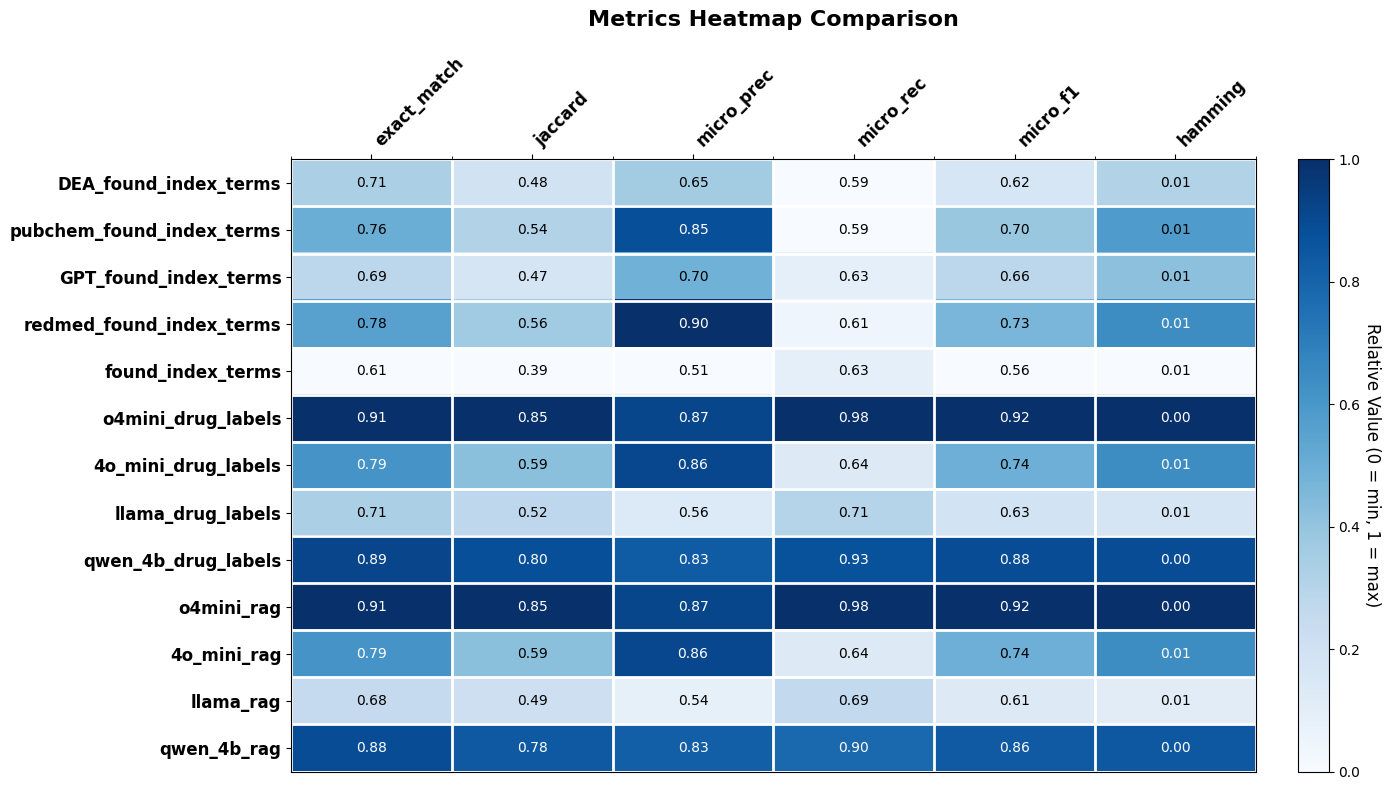

In [ ]:
# Create a heatmap of the metrics
data = metrics_df.values.astype(float)
col_min = data.min(axis=0)
col_max = data.max(axis=0)
norm_data = (data - col_min) / (col_max - col_min + 1e-8)
 
hamming_idx = list(metrics_df.columns).index('hamming')
norm_data[:, hamming_idx] = 1.0 - norm_data[:, hamming_idx]


# Create the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the heatmap with a clean blue gradient (light=low, dark=high)
cmap = plt.get_cmap('Blues')
im = ax.imshow(norm_data, aspect='auto', cmap=cmap)

# Colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Relative Value (0 = min, 1 = max)', rotation=270, labelpad=15, fontsize=12)

# Axis ticks and labels
ax.set_xticks(np.arange(data.shape[1]))
ax.set_xticklabels(metrics_df.columns, fontsize=12, fontweight='bold', rotation=45, ha='left')
ax.set_yticks(np.arange(data.shape[0]))
ax.set_yticklabels(metrics_df.index, fontsize=12, fontweight='bold')

# Move x-axis to the top
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

# Annotate each cell with the original metric value, formatted to two decimals
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        text_color = 'white' if norm_data[i, j] > 0.6 else 'black'
        ax.text(j, i, f"{data[i, j]:.2f}", ha='center', va='center', color=text_color, fontsize=10)

# Add white grid lines between cells for clarity
ax.set_xticks(np.arange(-.5, data.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-.5, data.shape[0], 1), minor=True)
ax.grid(which='minor', color='white', linestyle='-', linewidth=2)
ax.tick_params(which='minor', bottom=False, left=False)

# Title
plt.title('Metrics Heatmap Comparison', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()


Unique drugs in truth labels: ['CBD', 'Codeine', 'Fentanyl', 'Hydrocodone', 'LSD', 'Lorazepam', 'Marijuana', 'Methamphetamine', 'Morphine', 'Oxycodone', 'Psilocybin']
Drug: CBD, Column: DEA_found_index_terms                                                   text label  tweet_num  \
41  CBD oil which is from the cannabis plant is fi...     T       2806   

         found_terms        found_index_terms GPT_found_terms  \
41  ['cbd', 'plant']  [cbd, delta-9-thc-cooh]         ['cbd']   

   GPT_found_index_terms pubchem_found_terms pubchem_found_index_terms  \
41                 [cbd]             ['cbd']                     [cbd]   

   redmed_found_terms  ...                     o4mini_response_entity_linking  \
41            ['cbd']  ...  [\n  {"index_term": "CBD", "matched_phrase": "...   

   o4mini_drug_labels                    qwen_4b_response_entity_linking  \
41   [cbd, marijuana]  <think>\nOkay, let's tackle this query. The us...   

   qwen_4b_drug_labels                      ll

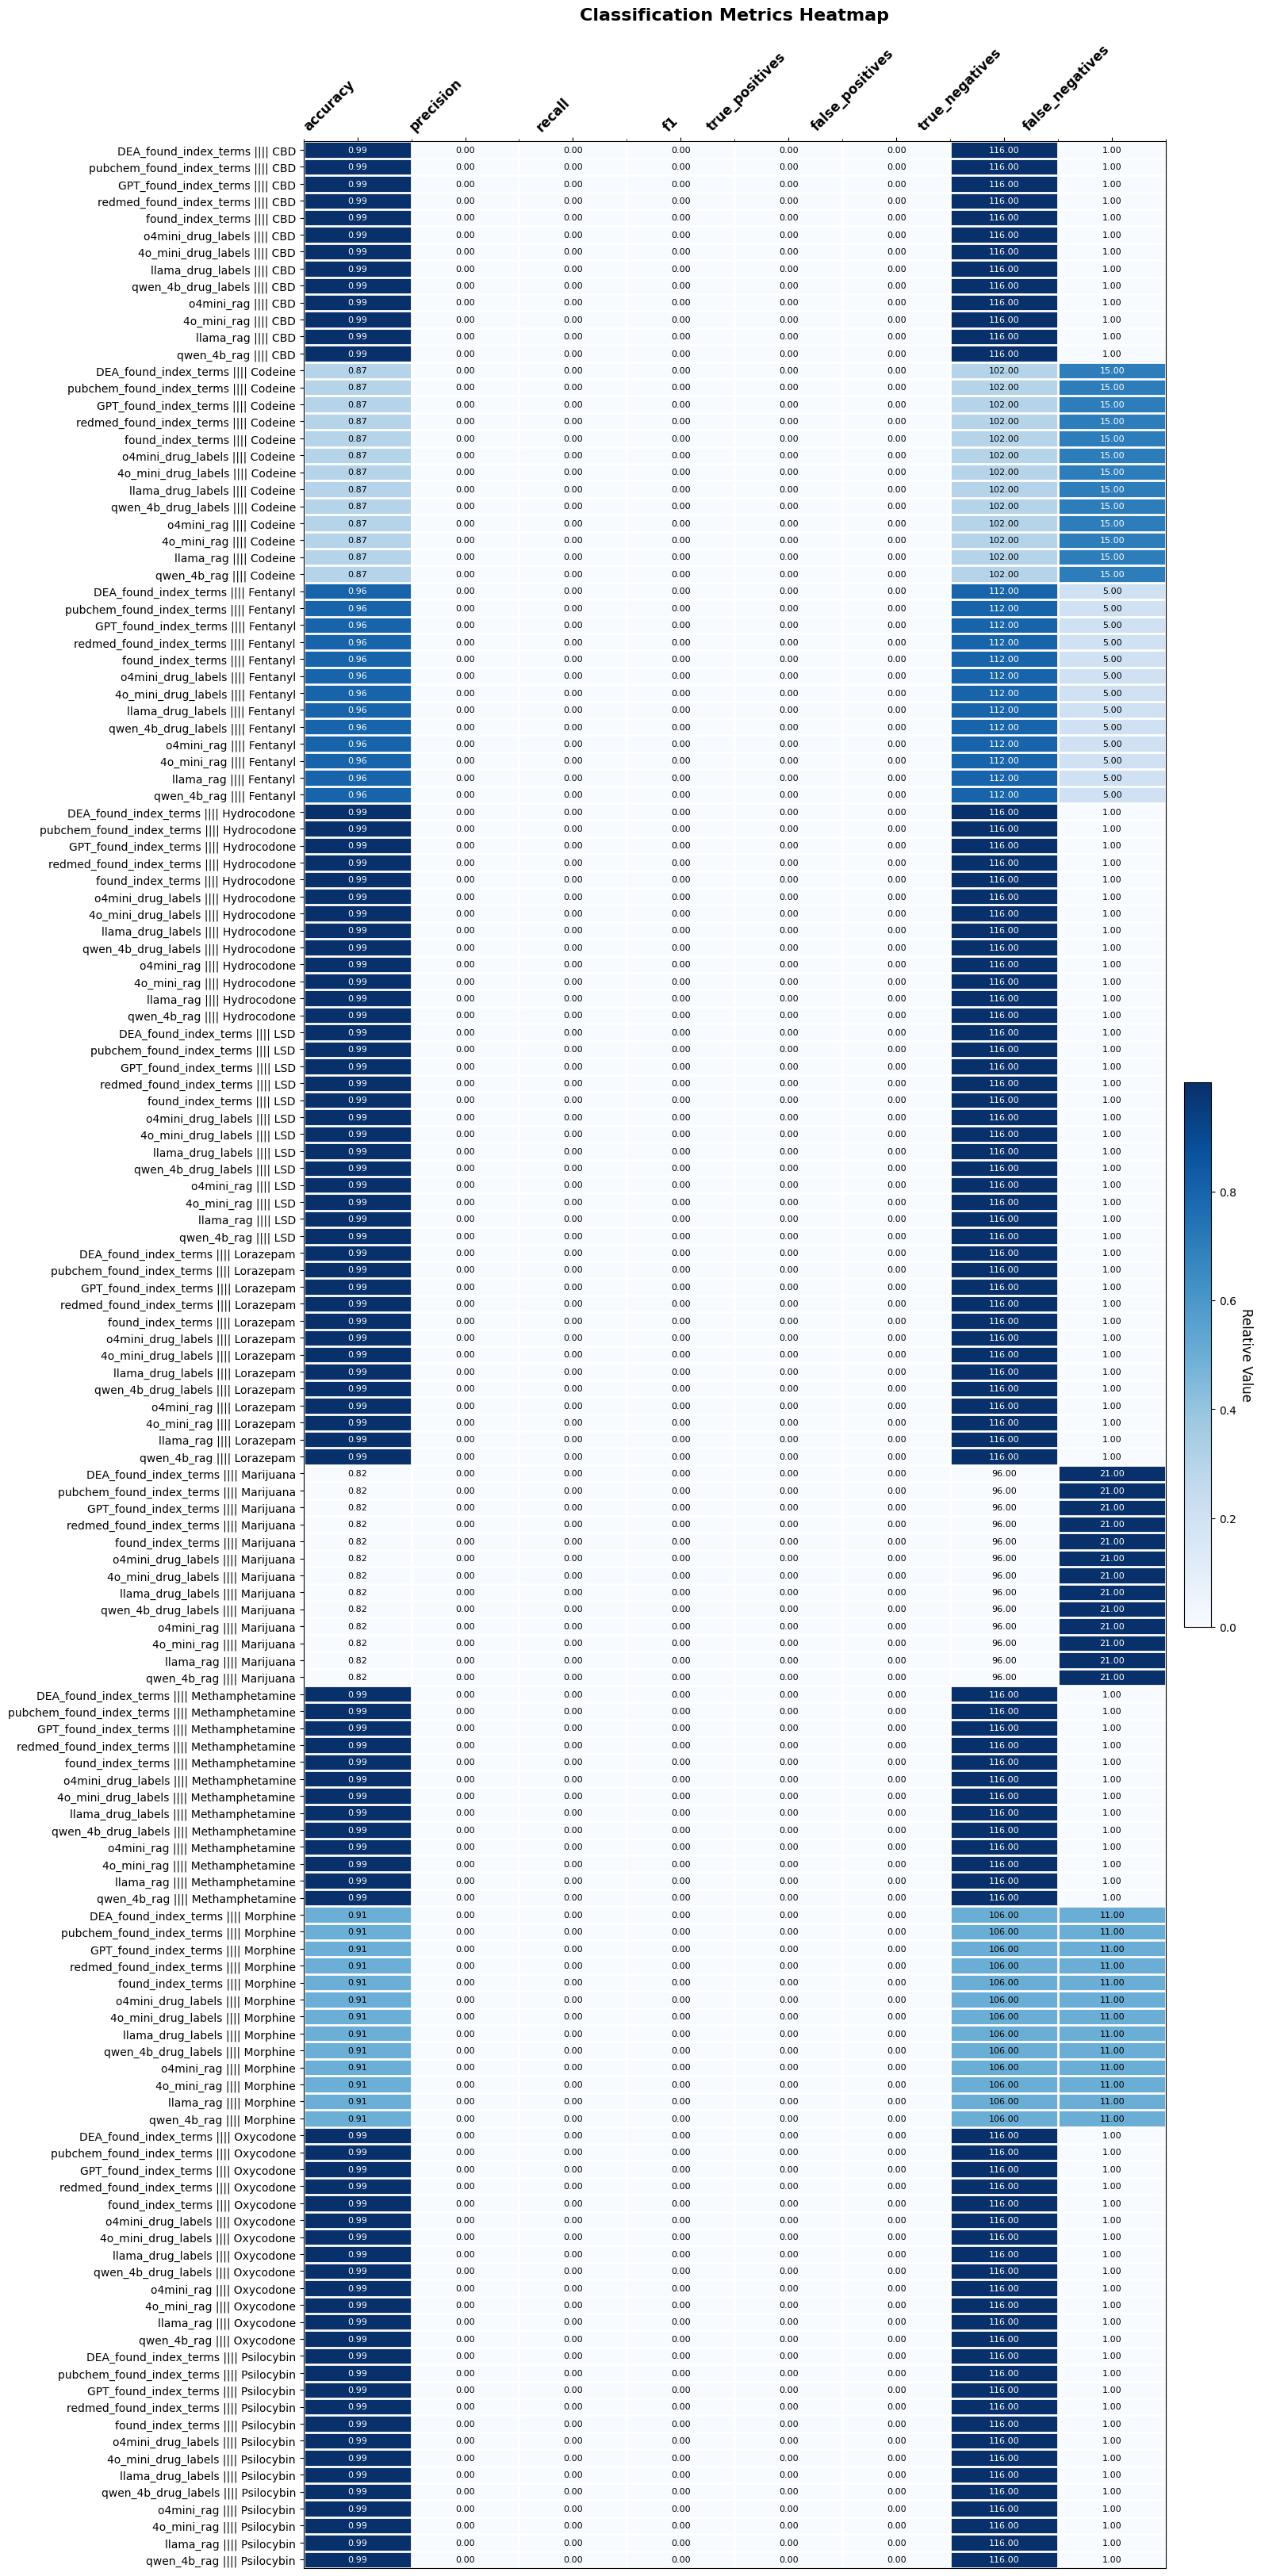

In [ ]:
######################################################################
# Individual drug metrics (binary)
########################################################################
truth_drugs = sorted(set(
    drug for lst in tweets['drugs_mentioned'] for drug in lst
))
print(f"Unique drugs in truth labels: {(truth_drugs)}")
results = []

# for each prediction column and each drug, compute metrics
for drug in truth_drugs:
    for col in LIST_COLS:
        # binary vectors: True if drug is in the list
        y_true = tweets['drugs_mentioned'].apply(lambda lst: drug in lst)
        true = tweets[y_true]['drugs_mentioned']
        print(f"Drug: {drug}, Column: {col}  {true}")

        y_pred = tweets[col].apply(lambda lst: drug in lst)
        
        tp = int(((y_true) & (y_pred)).sum())
        fp = int((~y_true & y_pred).sum())
        tn = int((~y_true & ~y_pred).sum())
        fn = int((y_true & ~y_pred).sum())
        
        # metrics (handle zero‐division safely)
        acc  = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)
        
        results.append({
            'column':         col,
            'drug':           drug,
            'accuracy':       acc,
            'precision':      prec,
            'recall':         rec,
            'f1':             f1,
            'true_positives': tp,
            'false_positives':fp,
            'true_negatives': tn,
            'false_negatives':fn
        })

metrics_df = pd.DataFrame(results)
# or pivot columns × drugs matrix
# metrics_df.pivot(index='drug', columns='column', values='f1')
print(metrics_df)


# Define the numeric metric columns
numeric_cols = [
    'accuracy', 'precision', 'recall', 'f1',
    'true_positives', 'false_positives', 'true_negatives', 'false_negatives'
]

# Extract the numeric data matrix
data = metrics_df[numeric_cols].values.astype(float)

# Normalize each column to [0,1] for relative shading
col_min = data.min(axis=0)
col_max = data.max(axis=0)
norm_data = (data - col_min) / (col_max - col_min + 1e-8)

# Create the figure with dynamic height based on number of rows
fig, ax = plt.subplots(figsize=(16, len(metrics_df) * 0.2 + 4))

# Plot heatmap with clean blue gradient
cmap = plt.get_cmap('Blues')
im = ax.imshow(norm_data, aspect='auto', cmap=cmap)

# Add colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)
cbar.set_label('Relative Value', rotation=270, labelpad=15, fontsize=12)

# Configure axis ticks and labels
ax.set_xticks(np.arange(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, fontsize=12, fontweight='bold', rotation=45, ha='right')
ax.set_yticks(np.arange(len(metrics_df)))
ax.set_yticklabels(
    [f"{row['column']} |||| {row['drug']}" for _, row in metrics_df.iterrows()],
    fontsize=10
)

# Move x-axis to top
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

# Annotate each cell with its original value
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        color = 'white' if norm_data[i, j] > 0.6 else 'black'
        ax.text(j, i, f"{data[i, j]:.2f}", ha='center', va='center', color=color, fontsize=8)

# Add white grid lines between cells
ax.set_xticks(np.arange(-.5, len(numeric_cols), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(metrics_df), 1), minor=True)
ax.grid(which='minor', color='white', linestyle='-', linewidth=2)
ax.tick_params(which='minor', bottom=False, left=False)

# Title and layout
plt.title('Classification Metrics Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Binary Classification Results

In [ ]:
# helpers
def to_bool(x):
    if isinstance(x, bool):
        return x
    if isinstance(x, (int, float)): # 1 / 0 or 1.0 / 0.0
        return bool(x)
    if isinstance(x, str):
        return x.strip().upper() in {"TRUE", "T", "1"}
    return False

def list_to_bool(obj):
    if obj is None or obj == []:
        return False
    if isinstance(obj, str):
        try:
            import ast
            obj = ast.literal_eval(obj)
        except Exception:
            return False
    try:
        result = any(str(item).lower() != "other" for item in obj)
    except Exception as e:
        print(obj)
        print(e)
        return False
    return result

def metrics(y_true, y_pred):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[False, True]).ravel()
    return pd.Series({
        "accuracy":        acc,
        "precision":       prec,
        "recall":          rec,
        "f1":              f1,
        "true_positives":  tp,
        "false_positives": fp,
        "true_negatives":  tn,
        "false_negatives": fn,
    })
                   
labeled_tweets = tweets[tweets[TRUTH_COL].notnull()].copy()
labeled_tweets["combined_truth"] = labeled_tweets.apply(
    lambda r: to_bool(r[TRUTH_COL]) and list_to_bool(r[LIST_OF_DRUGS]), axis=1,
)

labeled_tweets[TRUTH_COL] = labeled_tweets[TRUTH_COL].apply(to_bool)

for col in PRED_COLS:
    labeled_tweets[col] = labeled_tweets[col].apply(to_bool)

for col in LIST_COLS:
    labeled_tweets[col] = labeled_tweets[col].apply(list_to_bool)

PRED_COLS.extend(LIST_COLS)

results = pd.concat(
    {col: metrics(labeled_tweets[TRUTH_COL], labeled_tweets[col]) for col in PRED_COLS},
    axis=1
).T.round(4)

display(results)

,accuracy,precision,recall,f1,true_positives,false_positives,true_negatives,false_negatives
o4mini_label,0.8205,0.6957,0.8205,0.7529,32.0,14.0,64.0,7.0
4o_mini_label,0.7863,0.6522,0.7692,0.7059,30.0,16.0,62.0,9.0
llama_label,0.7265,0.5660,0.7692,0.6522,30.0,23.0,55.0,9.0
qwen_4b_label,0.7778,0.6444,0.7436,0.6905,29.0,16.0,62.0,10.0
o4mini_label_short,0.8205,0.7143,0.7692,0.7407,30.0,12.0,66.0,9.0
4o_mini_label_short,0.7863,0.6750,0.6923,0.6835,27.0,13.0,65.0,12.0
llama_label_short,0.7949,0.6829,0.7179,0.7000,28.0,13.0,65.0,11.0
qwen_4b_label_short,0.6838,0.5172,0.7692,0.6186,30.0,28.0,50.0,9.0
label,0.5214,0.3951,0.8205,0.5333,32.0,49.0,29.0,7.0
DEA_found_index_terms,0.7179,0.5652,0.6667,0.6118,26.0,20.0,58.0,13.0


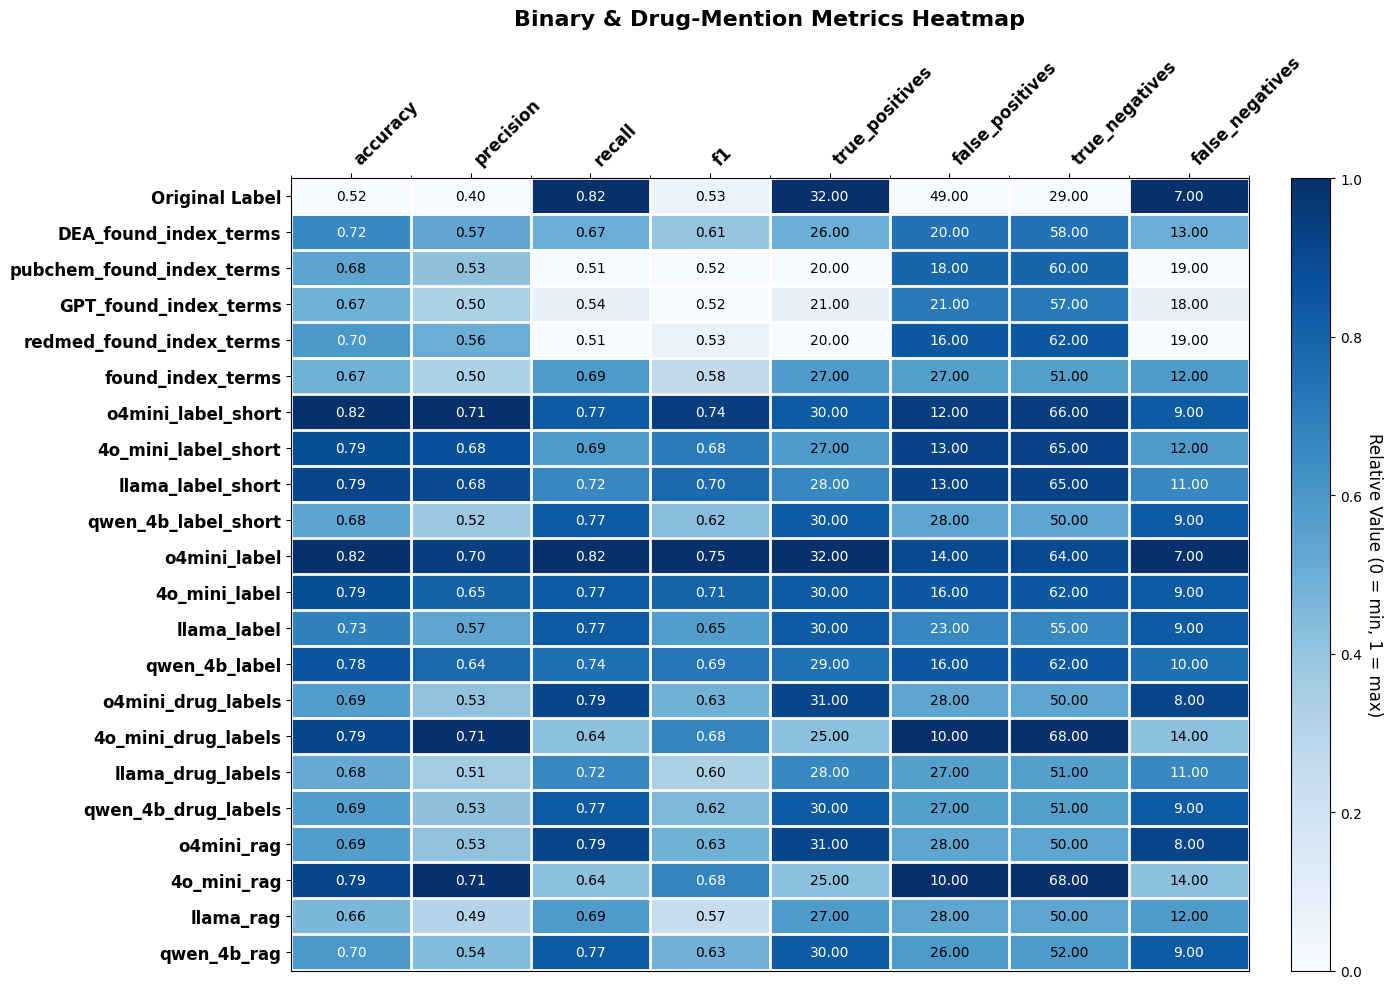

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Rename and reorder ROWS
df = results.copy().rename(index={'label': 'Original Label'})

# 2) Define each block of row‐labels
orig_idx        = ['Original Label']
index_terms_idx = [r for r in df.index if 'index_terms' in r]
short_idx       = [r for r in df.index if r.endswith('_label_short')]
plain_idx       = [r for r in df.index
                   if r.endswith('_label')
                   and not r.endswith('_label_short')
                   and r != 'Original Label']
drug_labels_idx = [r for r in df.index if r.endswith('_drug_labels')]
rag_idx         = [r for r in df.index if r.endswith('_rag')]

new_index = (
    orig_idx +
    index_terms_idx +
    short_idx +
    plain_idx +
    drug_labels_idx +
    rag_idx
)
df = df.loc[new_index]

# 3) Extract raw metrics and normalize per column
metrics = df.values.astype(float)
col_min  = metrics.min(axis=0)
col_max  = metrics.max(axis=0)
norm     = (metrics - col_min) / (col_max - col_min + 1e-8)

# 4) Flip only false_positives & false_negatives so that “less is darker”
false_cols = [
    i for i, c in enumerate(df.columns)
    if c in ('false_positives', 'false_negatives')
]
for j in false_cols:
    norm[:, j] = 1.0 - norm[:, j]

# 5) Plot heatmap
fig, ax = plt.subplots(figsize=(14, 10))
heatmap = ax.imshow(norm, aspect='auto', cmap=plt.get_cmap('Blues'))

# Colorbar
cbar = fig.colorbar(heatmap, ax=ax, orientation='vertical',
                    fraction=0.046, pad=0.04)
cbar.set_label('Relative Value (0 = min, 1 = max)',
               rotation=270, labelpad=15, fontsize=12)

# X/Y labels
ax.set_xticks(np.arange(df.shape[1]))
ax.set_xticklabels(df.columns, fontsize=12, fontweight='bold',
                   rotation=45, ha='left')
ax.set_yticks(np.arange(df.shape[0]))
ax.set_yticklabels(df.index, fontsize=12, fontweight='bold')

# Move x-axis to top
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

# Annotate values
for i in range(metrics.shape[0]):
    for j in range(metrics.shape[1]):
        txt_col = 'white' if norm[i, j] > 0.6 else 'black'
        ax.text(j, i, f"{metrics[i, j]:.2f}",
                ha='center', va='center',
                color=txt_col, fontsize=10)

# Grid lines
ax.set_xticks(np.arange(-.5, metrics.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-.5, metrics.shape[0], 1), minor=True)
ax.grid(which='minor', color='white', linestyle='-', linewidth=2)
ax.tick_params(which='minor', bottom=False, left=False)

# Title & layout
plt.title('Binary & Drug-Mention Metrics Heatmap',
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()





<Figure size 1200x1000 with 0 Axes>

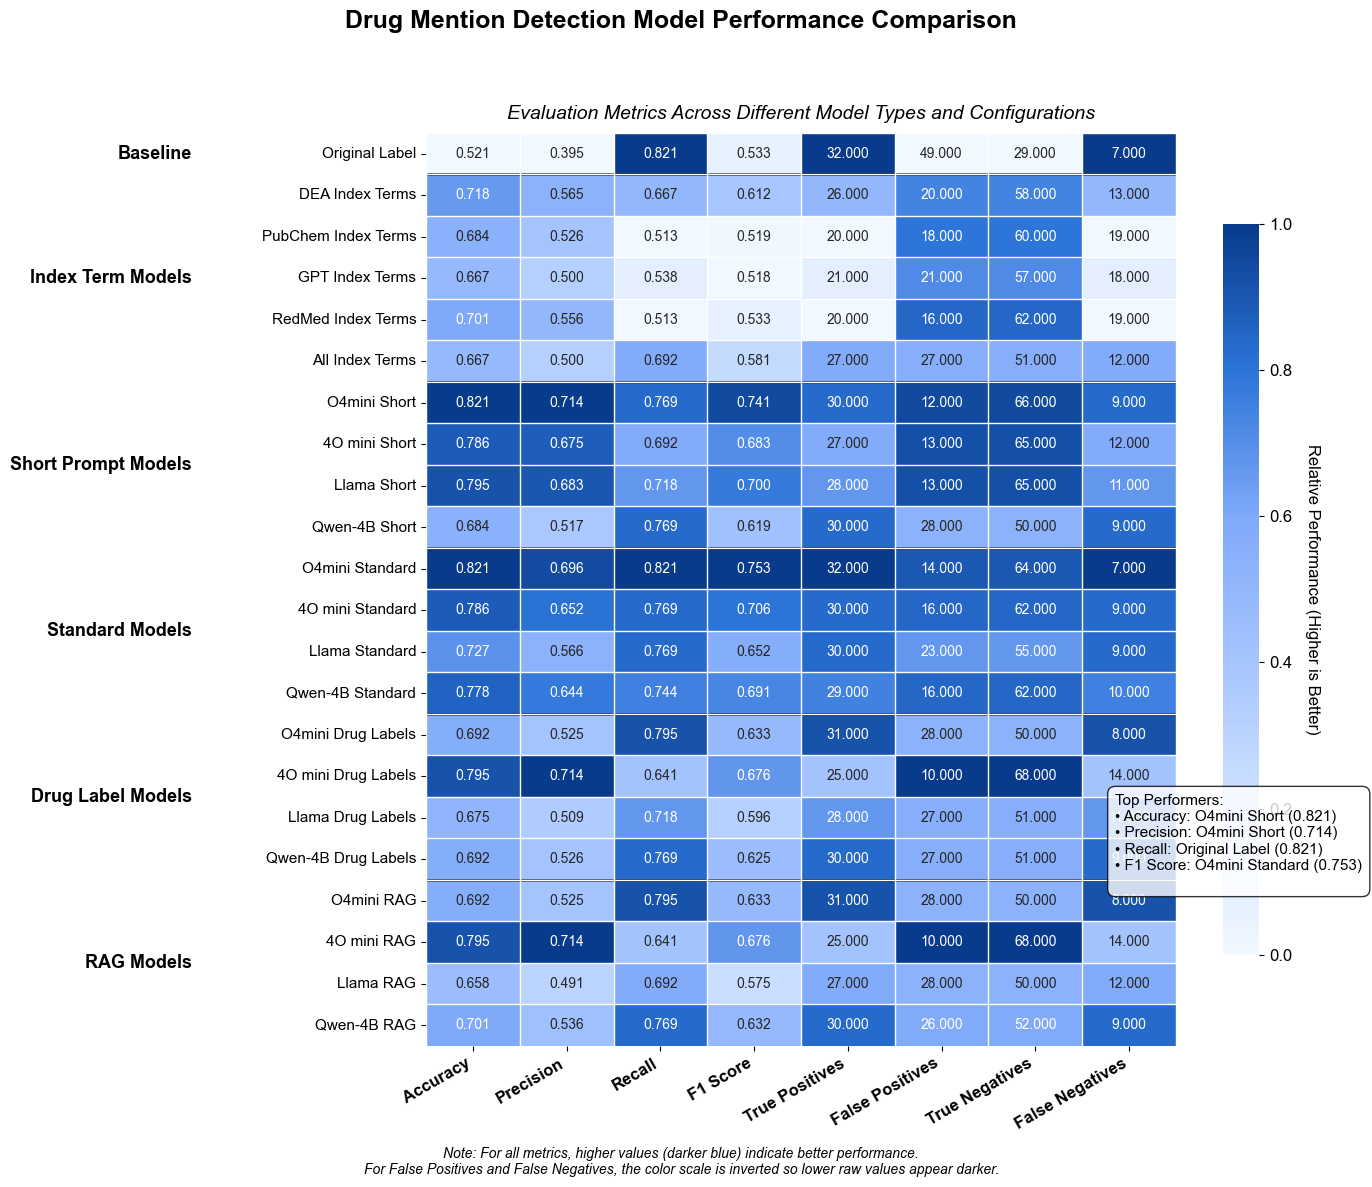

In [ ]:

# 1) Rename and organize rows with more professional names
row_mapping = {
    'o4mini_label': 'O4mini Standard',
    '4o_mini_label': '4O mini Standard',
    'llama_label': 'Llama Standard',
    'qwen_4b_label': 'Qwen-4B Standard',
    'o4mini_label_short': 'O4mini Short',
    '4o_mini_label_short': '4O mini Short',
    'llama_label_short': 'Llama Short',
    'qwen_4b_label_short': 'Qwen-4B Short',
    'label': 'Original Label',
    'DEA_found_index_terms': 'DEA Index Terms',
    'pubchem_found_index_terms': 'PubChem Index Terms',
    'GPT_found_index_terms': 'GPT Index Terms',
    'redmed_found_index_terms': 'RedMed Index Terms',
    'found_index_terms': 'All Index Terms',
    'o4mini_drug_labels': 'O4mini Drug Labels',
    '4o_mini_drug_labels': '4O mini Drug Labels',
    'llama_drug_labels': 'Llama Drug Labels',
    'qwen_4b_drug_labels': 'Qwen-4B Drug Labels',
    'o4mini_rag': 'O4mini RAG',
    '4o_mini_rag': '4O mini RAG',
    'llama_rag': 'Llama RAG',
    'qwen_4b_rag': 'Qwen-4B RAG'
}

# More formal column names
col_mapping = {
    'accuracy': 'Accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
    'f1': 'F1 Score',
    'true_positives': 'True Positives',
    'false_positives': 'False Positives',
    'true_negatives': 'True Negatives',
    'false_negatives': 'False Negatives'
}

# 2) Define logical grouping of models
orig_idx = ['label']
index_terms_idx = [r for r in results.index if 'index_terms' in r]
short_idx = [r for r in results.index if r.endswith('_label_short')]
plain_idx = [r for r in results.index 
             if r.endswith('_label') 
             and not r.endswith('_label_short') 
             and r != 'label']
drug_labels_idx = [r for r in results.index if r.endswith('_drug_labels')]
rag_idx = [r for r in results.index if r.endswith('_rag')]

# Order index for better visual organization
new_index = (
    orig_idx +
    index_terms_idx +
    short_idx +
    plain_idx +
    drug_labels_idx +
    rag_idx
)

# Create mapping for model categories
category_mapping = {}
categories = [
    ('Baseline', orig_idx),
    ('Index Term Models', index_terms_idx),
    ('Short Prompt Models', short_idx),
    ('Standard Models', plain_idx),
    ('Drug Label Models', drug_labels_idx),
    ('RAG Models', rag_idx)
]

for category, indices in categories:
    for idx in indices:
        category_mapping[idx] = category

# Reorder and rename the dataframe
df = results.loc[new_index].copy()
df.index = [row_mapping.get(idx, idx) for idx in df.index]
df.columns = [col_mapping.get(col, col) for col in df.columns]

# Create a column for categories
df['Category'] = [category_mapping.get(idx, 'Other') for idx in new_index]

# 3) Create a publication-quality heatmap
plt.figure(figsize=(12, 10))
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 12
})

# Set up the matplotlib figure with better margins
fig, ax = plt.subplots(figsize=(14, 12))
plt.subplots_adjust(left=0.2)

# Create a custom sequential colormap that works well in print (blue to white)
cmap = LinearSegmentedColormap.from_list('BlueWhite', 
                                         [(0, '#F1F8FF'),  # Very light blue
                                          (0.2, '#D0E3FF'),
                                          (0.4, '#A6C5FF'),
                                          (0.6, '#7FA9F9'),
                                          (0.8, '#2C74D8'),
                                          (1.0, '#083B8C')])  # Deep blue

# For false positives and negatives, we want lower to be better (darker)
metrics = df.iloc[:, :-1].values.astype(float)  # Exclude the Category column
col_min = metrics.min(axis=0)
col_max = metrics.max(axis=0)
norm = (metrics - col_min) / (col_max - col_min + 1e-8)

# Invert the color scale for false positives and false negatives
for j, col in enumerate(df.columns[:-1]):  # Exclude Category column
    if 'False' in col:
        norm[:, j] = 1.0 - norm[:, j]

# Create a DataFrame of normalized values for the heatmap
norm_df = pd.DataFrame(
    norm, 
    columns=df.columns[:-1],  # Exclude Category
    index=df.index
)

# Create the heatmap - use the normalized data but annotate with actual values
g = sns.heatmap(norm_df, cmap=cmap, annot=metrics, fmt='.3f', linewidths=.5,
            annot_kws={"size": 10, "fontweight": "medium"},
            cbar_kws={'label': 'Relative Performance', 'shrink': 0.8})

# Adjust color bar label
cbar = g.collections[0].colorbar
cbar.set_label('Relative Performance (Higher is Better)', rotation=270, labelpad=20, fontsize=12)

# Draw category boundaries and labels
prev_category = None
start_idx = 0

for i, (idx, row) in enumerate(df.iterrows()):
    category = row['Category']
    if category != prev_category:
        if i > 0:
            # Draw a stronger horizontal line between categories
            plt.axhline(y=i, color='black', linewidth=2, alpha=0.7)
            
            # Add category label in the margin
            midpoint = start_idx + (i - start_idx) / 2
            plt.text(-2.5, midpoint, prev_category, 
                     ha='right', va='center', fontsize=13, fontweight='bold')
            
        prev_category = category
        start_idx = i

# Add the last category label
midpoint = start_idx + (len(df) - start_idx) / 2
plt.text(-2.5, midpoint, prev_category, 
         ha='right', va='center', fontsize=13, fontweight='bold')

# Enhance the x-axis and y-axis labels
plt.ylabel('')
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', fontweight='bold')
g.set_yticklabels(g.get_yticklabels(), fontsize=11, fontweight='medium')

# Add a descriptive title and subtitle
plt.suptitle('Drug Mention Detection Model Performance Comparison', 
             fontsize=18, fontweight='bold', y=0.98)
plt.title('Evaluation Metrics Across Different Model Types and Configurations', 
          fontsize=14, style='italic', pad=10)

# Add a note about metrics
footnote = """Note: For all metrics, higher values (darker blue) indicate better performance.
For False Positives and False Negatives, the color scale is inverted so lower raw values appear darker."""

plt.figtext(0.5, 0.01, footnote, ha='center', fontsize=10, style='italic')

# Add grid for readability
for i in range(len(df.columns)):
    plt.axvline(x=i, color='white', linewidth=1)

for i in range(len(df)):
    plt.axhline(y=i, color='white', linewidth=1)

# Create legend for top performers
top_models = {
    'Accuracy': df['Accuracy'].idxmax(),
    'Precision': df['Precision'].idxmax(),
    'Recall': df['Recall'].idxmax(),
    'F1 Score': df['F1 Score'].idxmax()
}

legend_text = "Top Performers:\n"
for metric, model in top_models.items():
    legend_text += f"• {metric}: {model} ({df.loc[model, metric]:.3f})\n"

# Add legend
plt.figtext(0.81, 0.25, legend_text, fontsize=11, 
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Compare RAG Results

In [ ]:
rag_result = tweets[tweets['4o_mini_rag']!= 'NO_RAG_CHUNKS'].copy()
rag_result = rag_result[['text',
 'label',
 'tweet_num',
 '4o_mini_drug_labels',
 'o4mini_drug_labels',
 'qwen_4b_drug_labels',
 'llama_drug_labels',
 '4o_mini_rag',
 'o4mini_rag',
 'qwen_4b_rag',
 'llama_rag',
 'is_about_illicit_drugs',
 'drugs_mentioned']].copy()
rag_result

,text,label,tweet_num,4o_mini_drug_labels,o4mini_drug_labels,qwen_4b_drug_labels,llama_drug_labels,4o_mini_rag,o4mini_rag,qwen_4b_rag,llama_rag,is_about_illicit_drugs,drugs_mentioned
0,The guy was hanged in Singapore because he was...,T,14,[],[],[],[other],[],[],[],[other],F,[]
1,Ex heroin addict here and I endorse this messa...,T,194,[],[],[],[],[],[],[],[],F,[]
2,"Yeah, my uncle's GF died a horribly painful, s...",T,315,[],[morphine],[morphine],[morphine],[],[morphine],[morphine],[morphine],F,[Morphine]
3,Innovation drives shift in cannabis product de...,T,361,[],[marijuana],[marijuana],"[delta-9-thc-cooh, delta-8-thc-cooh, cbd]",[],[marijuana],[marijuana],"[delta-9-thc-cooh, delta-8-thc-cooh, cbd]",F,[Marijuana]
4,"When that codeine had u knocked all day, now u...",T,378,[codeine],[codeine],[codeine],[codeine],[codeine],[codeine],[codeine],[codeine],T,[Codeine]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,Chonk cat... did I just crack the enigma?,F,8147,[],[],[],[],[],[],[],[],F,[]
113,Tylenol can kill anyone and not because of pac...,T,8180,[],[],[],[],[],[],[],[],F,[]
114,My top 3 music of all time: 1) Kanye West - fl...,F,8188,[codeine],[codeine],[codeine],[codeine],[codeine],[codeine],[codeine],[codeine],F,[Codeine]
115,Naloxone is a drug that can temporarily revers...,T,8206,[],[],[],[],[],[],[],[codeine],F,[]


In [ ]:
:)

SyntaxError: unmatched ')' (1896645534.py, line 1)